<a href="https://colab.research.google.com/github/donbr/visionary_storytelling/blob/main/notebooks/ms_phi3_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions for the Phi3 Vision Language Model

- see the [model card](https://huggingface.co/microsoft/Phi-3-vision-128k-instruct) for additional detail
- as the current Phi 3 Vision model requires Flash Attention it will only run on very specific GPUs
  - on Google Colab, it will run on A100 or L4
  - will also run on T4 with an additional model parameter
  - refer to [model card README](https://huggingface.co/microsoft/Phi-3-vision-128k-instruct#running-on-windows-or-without-flash-attention) for additional detail on the fix
- Currently bleeding edge - Phi3 Vision model card directs devs to install  transformers using lates updates from GitHub

## Install Python Dependencies

In [1]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-_n7yc354
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-_n7yc354
  Resolved https://github.com/huggingface/transformers to commit 15585b81a525e3878321df4b13404c96690a2469
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -qU flash_attn accelerate

## Import necessary libraries

In [3]:
from PIL import Image
import requests
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor


## Hugging Face model configuration
- Load the Phi-3 Vision model and processor from Hugging Face

In [4]:
# Hugging Face model configuration

model_id = "microsoft/Phi-3-vision-128k-instruct"

# standard model config
# model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda", trust_remote_code=True, torch_dtype="auto")

# model config workaround for flash_attention_2 issues on older GPU architectures
# refer to [model card README](https://huggingface.co/microsoft/Phi-3-vision-128k-instruct#running-on-windows-or-without-flash-attention) for additional detail
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda", trust_remote_code=True, torch_dtype="auto", _attn_implementation="eager")

# processor configuration
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Visualize the Model Architecture

- Print the model architecture to understand its structure

In [5]:
# Visualize the Model Architecture

print(model)

Phi3VForCausalLM(
  (model): Phi3VModel(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (vision_embed_tokens): Phi3ImageEmbedding(
      (drop): Dropout(p=0.0, inplace=False)
      (wte): Embedding(32064, 3072, padding_idx=32000)
      (img_processor): CLIPVisionModel(
        (vision_model): CLIPVisionTransformer(
          (embeddings): CLIPVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
            (position_embedding): Embedding(577, 1024)
          )
          (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (encoder): CLIPEncoder(
            (layers): ModuleList(
              (0-23): 24 x CLIPEncoderLayer(
                (self_attn): CLIPAttention(
                  (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                  (v_proj): Linear(in_features=1024, out_features=1024, bias=True

## Setup the input for the Vision model

In [6]:
# Define the messages to be processed by the model

messages = [
    {"role": "user", "content": "<|image_1|>\nWhat is shown in this image?"},

]

# Load the image from a URL
url = "https://image.civitai.com/xG1nkqKTMzGDvpLrqFT7WA/15b17bf0-fb1a-4fb2-b952-beee07706068/width=832/00088-3178799381.jpeg"
image = Image.open(requests.get(url, stream=True).raw)

# Process the messages and image to create input tensors
prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")


## Setup and Run Vision model inference


In [7]:
# Define generation arguments for the model's response
generation_args = {
    "max_new_tokens": 500,
    "temperature": 0.0,
    "do_sample": False,
}

# Generate the response from the Vision model
generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)

# Remove input tokens from the generated response to get the actual output tokens
generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]

# Decode the response to get the final text output
response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


## Discover the Model's Insights!

In [8]:
print(response)

The image depicts a large white bear roaring in a snowy forest. In front of the bear, there is a person dressed in armor, seemingly in a battle-ready stance.


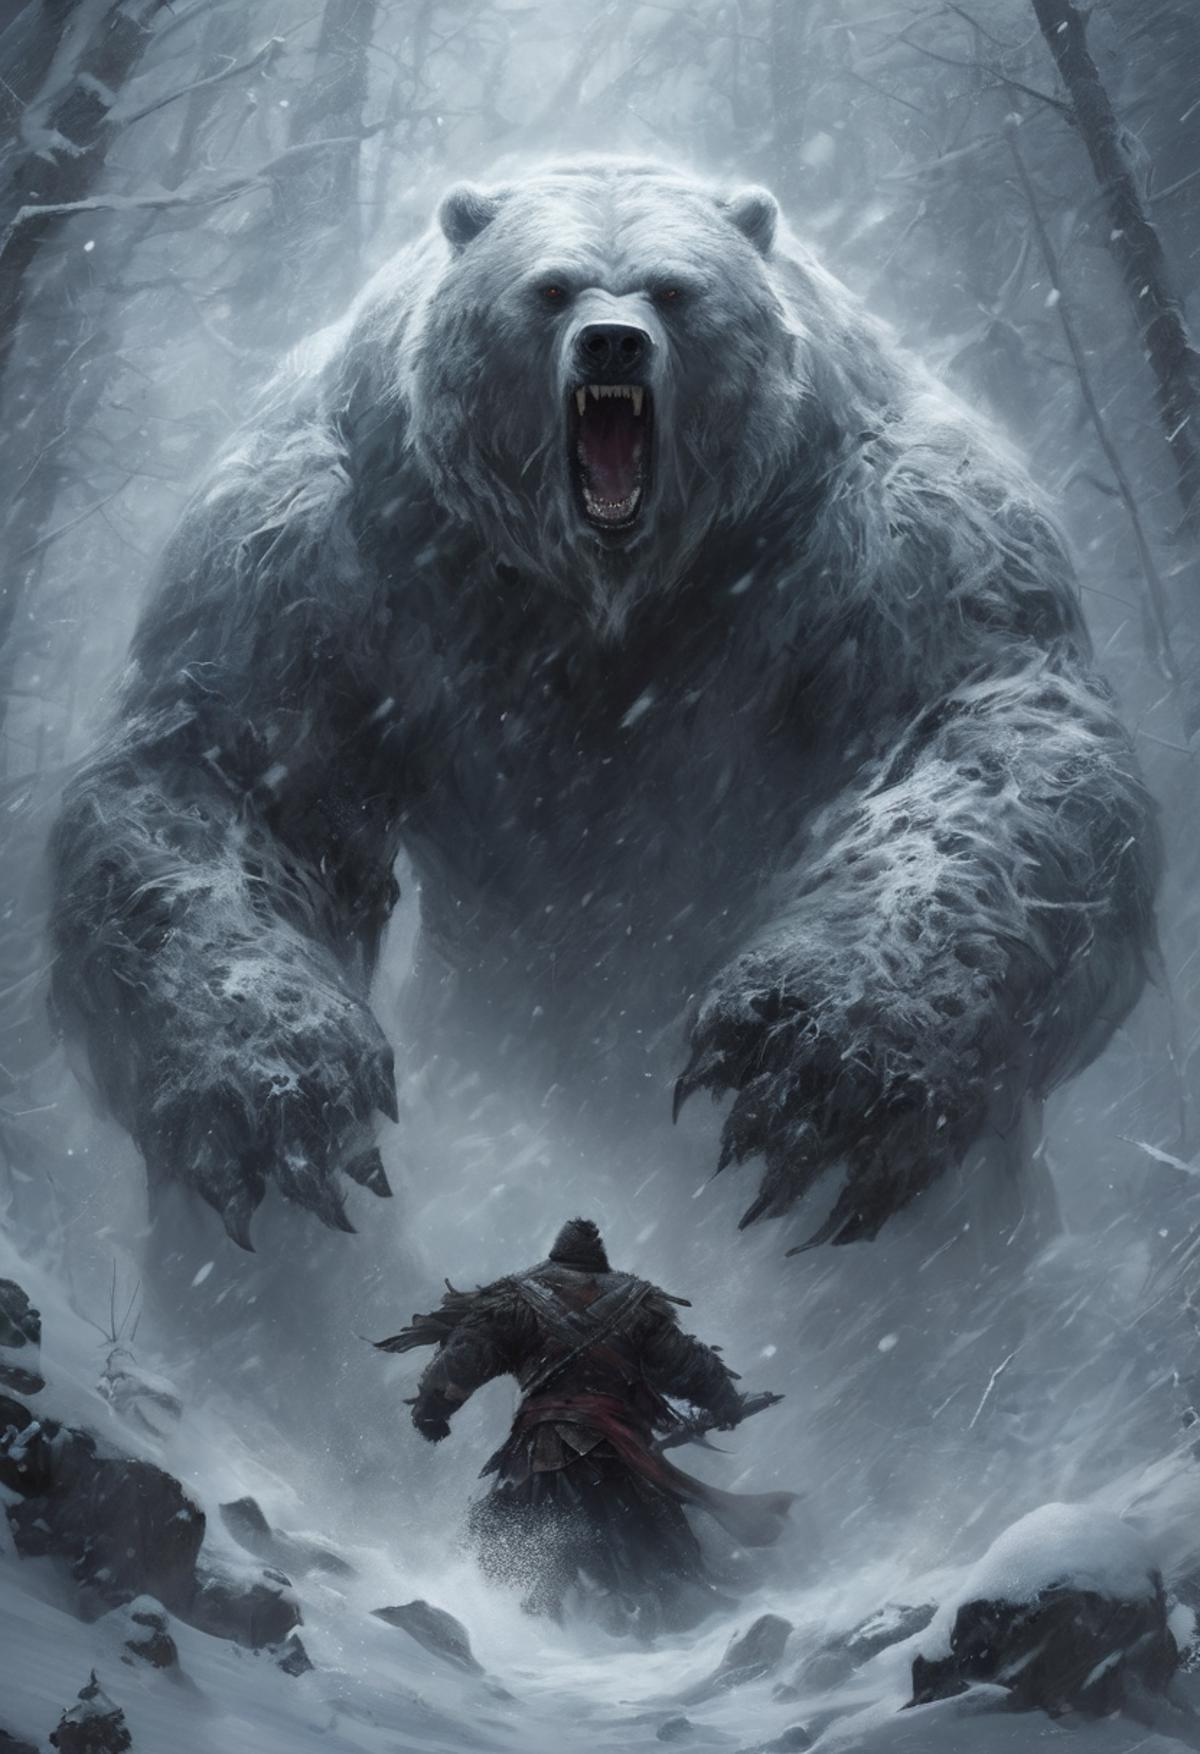

In [9]:
display(image)